In [2]:
import pandas as pd
import numpy as np
import re
import math
import pdb
from time import localtime, strftime
from datetime import datetime, time, date
import datetime
import os

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.plotly as py
import plotly.graph_objs as go

In [5]:
pd.options.display.max_colwidth = 50
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [6]:
sns.set_style('whitegrid')

# Exploration

In [7]:
loan = pd.read_csv('loan.csv')

/Users/ivypan/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.



In [8]:
loan.shape

(887379, 74)

In [9]:
loan['issue_date'] = pd.to_datetime(loan['issue_d'])
loan['issue_year'] = loan['issue_date'].apply(lambda x: x.year)

loan['term_clean'] = loan['term'].apply(lambda x: x.split(' ')[1]).astype(int)
loan['emp_length_clean'] = loan['emp_length'].str.extract('(\d+)')

/Users/ivypan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



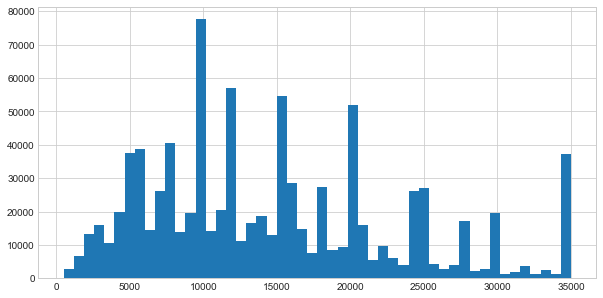

In [9]:
fig, ax = plt.subplots()
loan.loan_amnt.hist(bins = 50)
fig.set_size_inches(10, 5)

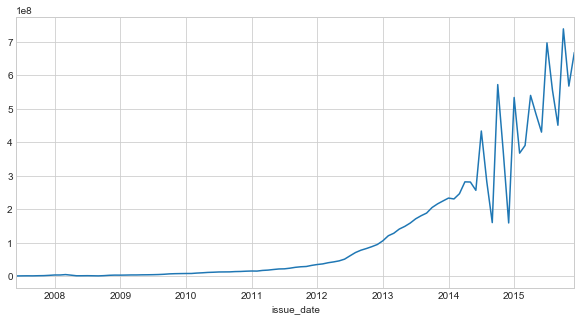

In [10]:
# loan amounts over time
loan.groupby('issue_date').loan_amnt.sum().plot(figsize = (10, 5))

In [11]:
loan.term_clean.value_counts()/loan.shape[0]

36    0.699955
60    0.300045
Name: term_clean, dtype: float64

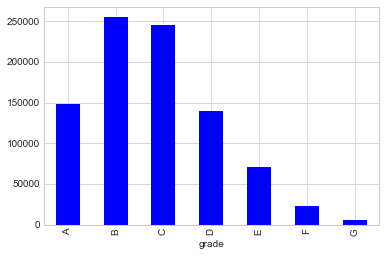

In [12]:
# breakdown of loans by grade
loan.groupby('grade').size().plot(kind = 'bar', color = 'blue')

In [121]:
(loan.groupby('grade').size()/loan.shape[0]).rename('perc_loan').reset_index()

,grade,perc_loan
0,A,0.167011
1,B,0.286839
2,C,0.277063
3,D,0.157252
4,E,0.079678
5,F,0.025971
6,G,0.006186


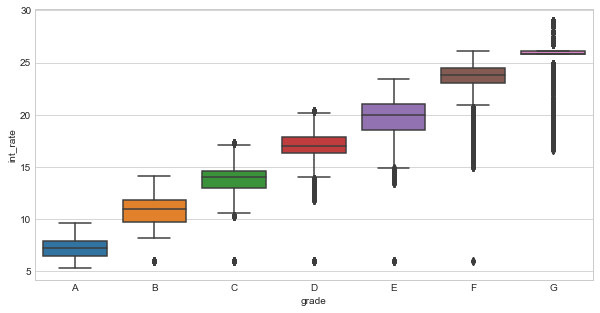

In [116]:
# interest loans per loan grade 
# higher interest rates for higher loan grades

fig, ax = plt.subplots()
sns.boxplot(x = 'grade', y = 'int_rate', data = loan.sort_values('grade'))
fig.set_size_inches(10, 5)

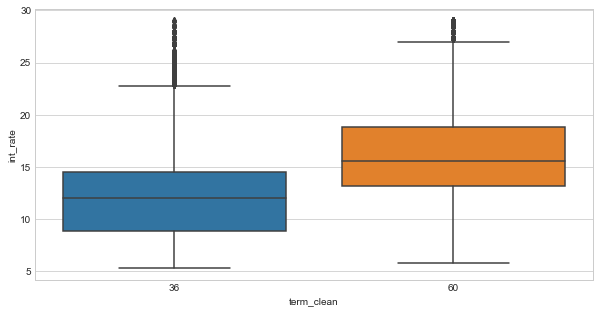

In [125]:
fig, ax = plt.subplots()
sns.boxplot(x = 'term_clean', y = 'int_rate', data = loan.sort_values('grade'))
fig.set_size_inches(10, 5)

In [119]:
loan.groupby('grade').int_rate.median().rename('median').reset_index()

,grade,median
0,A,7.26
1,B,10.99
2,C,13.99
3,D,16.99
4,E,19.99
5,F,23.76
6,G,25.83


In [17]:
def fill_regex(df, col, pattern, val):
    df.loc[df['loan_status'].str.contains(pattern, case = False, regex = True, na = False), col] = val

In [18]:
# categorize loan statuses
loan.loc[:, 'status'] = None

fill_regex(loan, 'status', 'paid', 'good')
fill_regex(loan, 'status', 'off|late|default', 'bad')
loan.loc[loan['status'].isnull(), 'status'] = 'other'

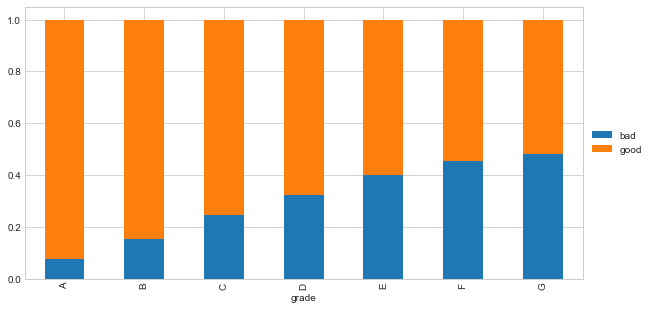

In [20]:
# categorize good and bad loans by grade
loan[loan['status'] != 'other'].groupby(['grade', 'status']).size().groupby(level = [0]).apply(lambda x: x / x.sum()).unstack().plot(kind = 'bar', stacked = True, figsize = (10, 5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [21]:
# ~10k difference between bad and good loans for each grade
loan.groupby(['grade', 'status']).annual_inc.agg(['mean', 'median'])

mean   median
grade status                       
A     bad     70615.590685  60000.0
      good    80478.399100  70000.0
      other   89899.779630  76000.0
B     bad     65082.443453  55000.0
      good    72412.257979  62000.0
      other   77382.341518  65000.0
C     bad     64681.607773  55000.0
      good    71437.890333  60000.0
      other   72237.393485  61000.0
D     bad     64824.268655  55000.0
      good    71301.281383  60232.0
      other   69145.445472  60000.0
E     bad     68915.776194  60000.0
      good    77465.551105  66000.0
      other   71237.167355  60000.0
F     bad     70803.777012  62400.0
      good    80141.177268  70000.0
      other   72466.889885  62000.0
G     bad     80008.243770  70000.0
      good    90449.595710  75000.0
      other   75474.895072  64800.0

In [22]:
loan['perc_paid'] = loan['total_pymnt']/loan['funded_amnt']

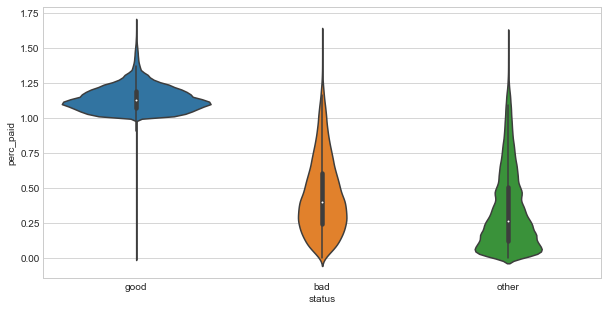

In [23]:
fig, ax = plt.subplots()
sns.violinplot(x = 'status', y = 'perc_paid', data = loan)
fig.set_size_inches(10, 5)

In [24]:
# breakdown of payments by grade by year 
annuals = loan.groupby(['issue_year', 'grade']).agg({'loan_amnt' : 'sum', 'total_pymnt' : 'sum', 'total_rec_prncp' : 
                                           'sum', 'total_rec_int' : 'sum', 'total_rec_late_fee' : 'sum'}).reset_index()

In [25]:
annualt = pd.melt(annuals, id_vars = ['issue_year', 'grade'], value_vars = ['total_rec_int', 'total_rec_prncp', 'total_rec_late_fee'], var_name = 'type', value_name = 'amt')

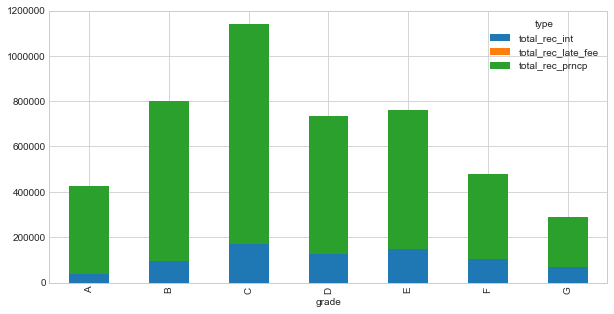

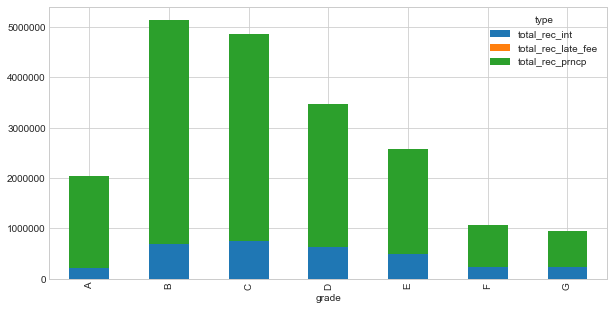

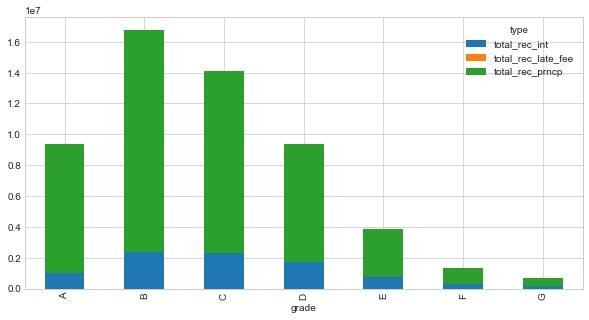

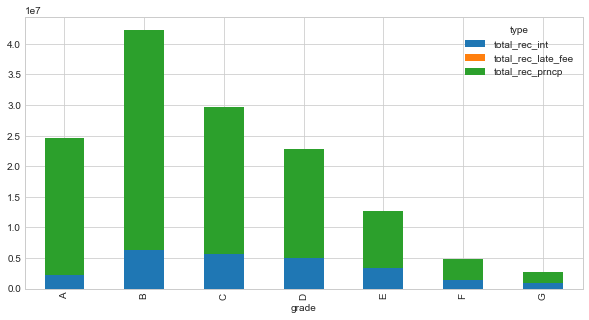

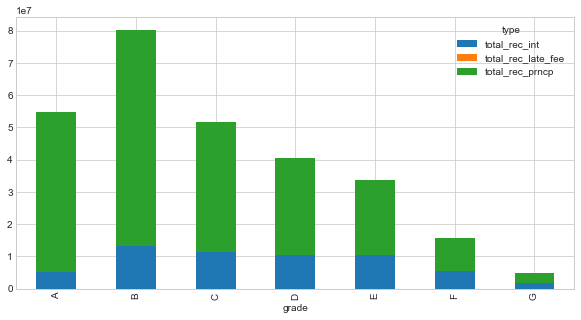

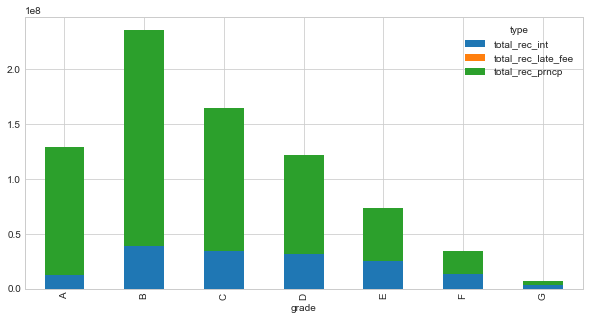

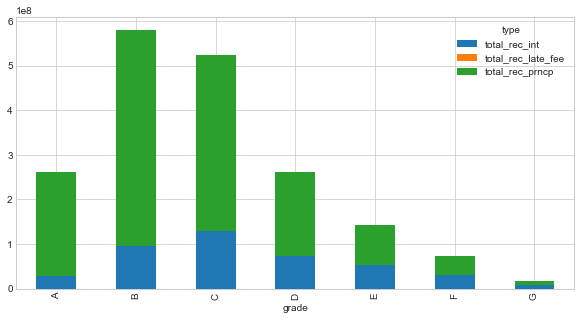

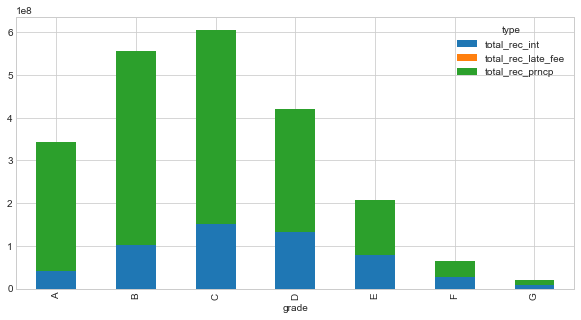

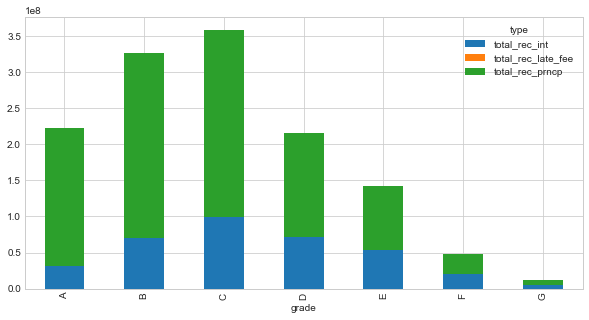

In [26]:
for name, grp in annualt.groupby('issue_year'):
    grp.groupby(['grade', 'type'])['amt'].sum().unstack().plot(kind = 'bar', stacked = True, figsize = (10, 5))

# Business Analysis

In [10]:
# filter to only closed loans in order to determine loss rate
closed_loans = loan[loan['loan_status'].str.contains('paid|charged|default', regex = True, case = False, na = False)]

In [150]:
# loans closed per year 
closed_loans.groupby('issue_year').id.nunique().rename('closed_loans').reset_index()

,issue_year,closed_loans
0,2007,603
1,2008,2393
2,2009,5281
3,2010,12523
4,2011,19683
5,2012,49591
6,2013,71414
7,2014,69307
8,2015,26144


In [12]:
# determine net loss in principal 
# total returns = interest payments + late fees + recoveries 
# losses = losses in principal - total returns 
closed_loans['charge_off_principal'] = (closed_loans['loan_amnt'] - closed_loans['total_rec_prncp']).clip(0) # for prin > loan amt
closed_loans['total_int_and_fees'] = closed_loans['total_rec_int'] + closed_loans['total_rec_late_fee'] + closed_loans['recoveries']
closed_loans['net_losses'] = closed_loans['charge_off_principal'] - closed_loans['total_int_and_fees'] + closed_loans['collection_recovery_fee']
closed_loans['net_loss_rate'] = closed_loans['net_losses'] / closed_loans['loan_amnt']

/Users/ivypan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/ivypan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/ivypan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

In [13]:
# calculate weighted returns per grade 
grade_returns = -closed_loans.groupby(['grade']).net_losses.sum() / closed_loans.groupby(['grade']).loan_amnt.sum()

In [14]:
grade_returns.rename('returns').reset_index()

,grade,returns
0,A,0.037600
1,B,0.038790
2,C,0.002978
3,D,-0.032707
4,E,-0.070631
5,F,-0.096153
6,G,-0.106784


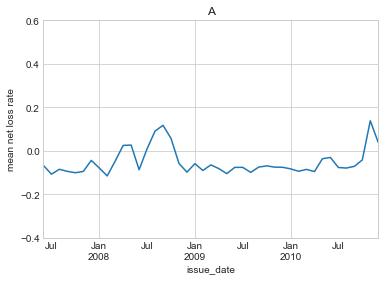

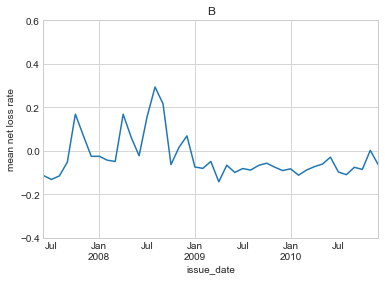

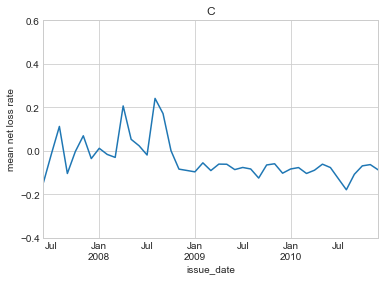

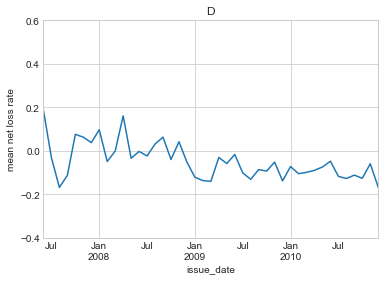

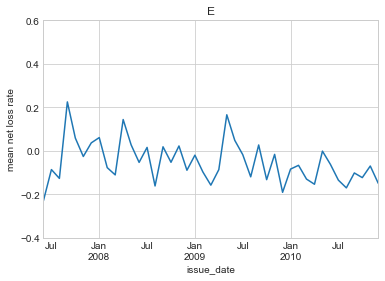

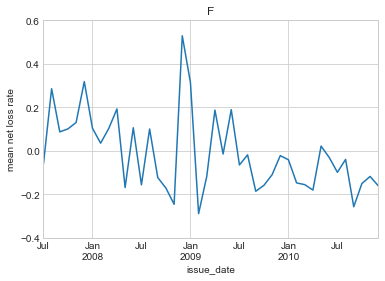

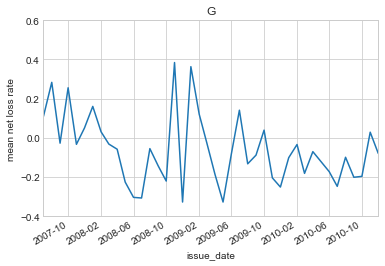

In [161]:
for grade in closed_loans['grade'].sort_values().unique():
    fig, ax = plt.subplots()
    closed_loans[(closed_loans['issue_year'] < 2011) & (closed_loans['grade'] == grade)].groupby('issue_date').net_loss_rate.mean().plot()
    
    plt.title(grade)
    plt.ylim(-0.4, 0.6)
    plt.ylabel('mean net loss rate')

# Model 
### Build a logistic regression model to predict probability of default

In [ ]:
closed_loans['default'] = closed_loans['loan_status'].map(lambda x: 1 if x in ['Charged Off','Default','Does not meet the credit policy. Status:Charged Off'] else 0)

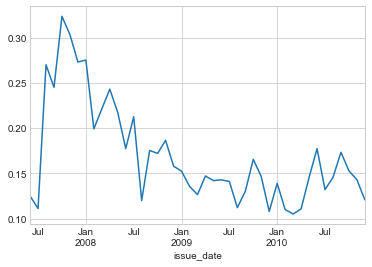

In [147]:
# plot until 2011 to account for loans opened in the later years
closed_loans[closed_loans['issue_year'] < 2011].groupby('issue_date').default.mean().plot()

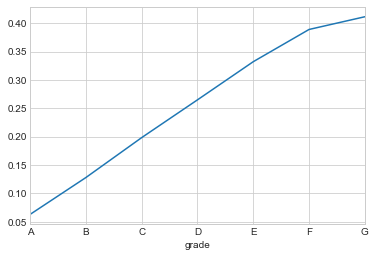

In [138]:
closed_loans.groupby(['grade']).default.mean().plot()

In [83]:
feats = ['issue_date', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'loan_amnt', 'grade', 'annual_inc', 'delinq_2yrs', 'default']

In [84]:
sub = closed_loans[feats]

In [88]:
sub.isnull().sum()/sub.shape[0]

issue_date        0.000000
inq_last_6mths    0.000113
open_acc          0.000113
pub_rec           0.000113
revol_bal         0.000000
loan_amnt         0.000000
grade             0.000000
annual_inc        0.000016
delinq_2yrs       0.000113
default           0.000000
dtype: float64

In [99]:
sub = closed_loans[feats]
sub = pd.concat([sub, pd.get_dummies(sub['grade'])], axis = 1).drop('grade', 1)

In [101]:
# filter training set to dataset between 2007-2010 to account for loan durations of up to 60 months 
train = sub[sub['issue_date'] < '2011-01-01'][[col for col in sub.columns if 'issue_date' not in col]]

In [102]:
test = closed_loans[(closed_loans['issue_date'] >= '2011-01-01') & (closed_loans['issue_date'] < '2012-01-01')]
test = pd.concat([test, pd.get_dummies(test['grade'])], axis = 1).drop('grade', 1)

In [103]:
for col in [col for col in train.columns if train[col].isnull().any() == True]:
    train.loc[train[col].isnull(), col] = train[col].mean()

In [129]:
# correlation matrix of training features 
train_corr = train.corr()

In [130]:
train_corr

,inq_last_6mths,open_acc,pub_rec,revol_bal,loan_amnt,annual_inc,delinq_2yrs,default,A,B,C,D,E,F,G
inq_last_6mths,1.000000,0.104366,0.072957,0.010641,-0.033195,0.023654,0.024509,0.148236,-0.142650,-0.086173,0.013289,0.082610,0.111511,0.103441,0.119498
open_acc,0.104366,1.000000,-0.000370,0.259220,0.193934,0.148966,0.021538,-0.000622,0.024824,-0.024203,-0.029727,-0.008355,0.012537,0.031417,0.063532
pub_rec,0.072957,-0.000370,1.000000,-0.040101,-0.047557,-0.006678,0.009561,0.061768,-0.102231,-0.022717,0.042785,0.046018,0.039856,0.022452,0.024161
revol_bal,0.010641,0.259220,-0.040101,1.000000,0.248118,0.247383,-0.035870,0.032011,-0.057936,0.002297,0.001093,0.019368,0.009356,0.032840,0.060288
loan_amnt,-0.033195,0.193934,-0.047557,0.248118,1.000000,0.233021,-0.027090,0.023720,-0.161781,0.058166,-0.026743,0.030667,0.059018,0.087551,0.082153
annual_inc,0.023654,0.148966,-0.006678,0.247383,0.233021,1.000000,0.018438,-0.022713,-0.011685,0.004468,-0.009740,-0.006258,0.006091,0.022779,0.030986
delinq_2yrs,0.024509,0.021538,0.009561,-0.035870,-0.027090,0.018438,1.000000,0.009791,-0.116397,-0.063981,0.042752,0.077599,0.069158,0.034403,0.049228
default,0.148236,-0.000622,0.061768,0.032011,0.023720,-0.022713,0.009791,1.000000,-0.140790,-0.045248,0.018484,0.073353,0.081209,0.082418,0.067222
A,-0.142650,0.024824,-0.102231,-0.057936,-0.161781,-0.011685,-0.116397,-0.140790,1.000000,-0.324206,-0.284773,-0.222359,-0.152777,-0.088014,-0.063872
B,-0.086173,-0.024203,-0.022717,0.002297,0.058166,0.004468,-0.063981,-0.045248,-0.324206,1.000000,-0.341263,-0.266468,-0.183083,-0.105474,-0.076543


In [123]:
# determine variance of features 
train.var(axis = 0).sort_values(ascending = False)

annual_inc        6.034414e+09
revol_bal         7.314182e+08
loan_amnt         4.064095e+07
open_acc          2.142705e+01
inq_last_6mths    3.507108e+00
delinq_2yrs       2.647894e-01
B                 2.015250e-01
C                 1.774456e-01
A                 1.676004e-01
D                 1.306493e-01
default           1.278761e-01
E                 7.311857e-02
pub_rec           6.673454e-02
F                 2.706297e-02
G                 1.463578e-02
dtype: float64

In [132]:
closed_loans.var(axis = 0).agg(['mean', 'median'])

mean      8.319229e+12
median    5.744273e+02
dtype: float64

In [105]:
import statsmodels.api as sm
model = sm.Logit(train['default'], train[[col for col in train.columns if 'default' not in col]])
result = model.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.397340
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                20800
Model:                          Logit   Df Residuals:                    20786
Method:                           MLE   Df Model:                           13
Date:                Thu, 22 Feb 2018   Pseudo R-squ.:                 0.06205
Time:                        21:59:45   Log-Likelihood:                -8264.7
converged:                       True   LL-Null:                       -8811.4
                                        LLR p-value:                1.450e-225
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
inq_last_6mths     0.1260      0.010     13.187      0.000       0.107       0.145
open_acc         

In [106]:
test['predicted_prob_def'] = result.predict(test[[col for col in train.columns if 'default' not in col]])

# invest in loans where predicted prob default is less than the mean default
buy_loans = test1[test1['predicted_prob_def'] <= test1['predicted_prob_def'].mean()]

print -buy_loans['net_losses'].sum() / buy_loans['loan_amnt'].sum() # invest only in loans where predicted default prob < mean default prob
print -test1['net_losses'].sum() / test1['loan_amnt'].sum() # if invest in all loans

0.0761466051995
0.0634582535419


In [107]:
test['predicted_prob_def'].describe()

count    19683.000000
mean         0.129038
std          0.067449
min          0.000328
25%          0.060632
50%          0.121866
75%          0.171418
max          0.490348
Name: predicted_prob_def, dtype: float64

## Plot Distribution of Train and Test Features

Text(0.5,1,u'Train Set Loan Grade Distribution')

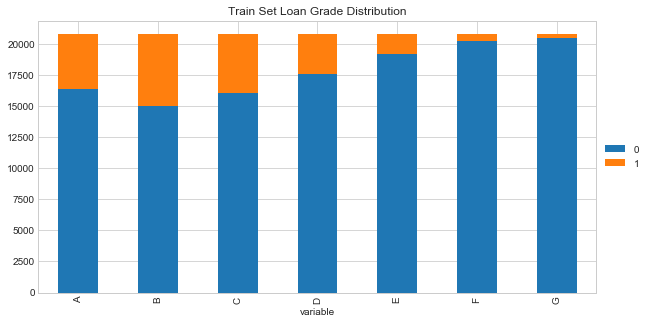

In [113]:
pd.melt(train.iloc[:, 8:], value_vars = ['A', 'B', 'C', 'D', 'E', 'F', \
                                          'G']).groupby(['variable', 'value']).size().unstack().plot(kind = 'bar', stacked = True, figsize = (10, 5))
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('Train Set Loan Grade Distribution')

Text(0.5,1,u'Test Set Loan Grade Distribution')

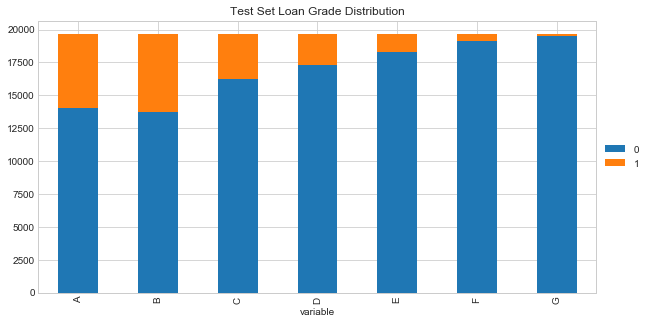

In [114]:
pd.melt(test.iloc[:, 82:89], value_vars = ['A', 'B', 'C', 'D', 'E', 'F', \
                                          'G']).groupby(['variable', 'value']).size().unstack().plot(kind = 'bar', stacked = True, figsize = (10, 5))
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('Test Set Loan Grade Distribution')

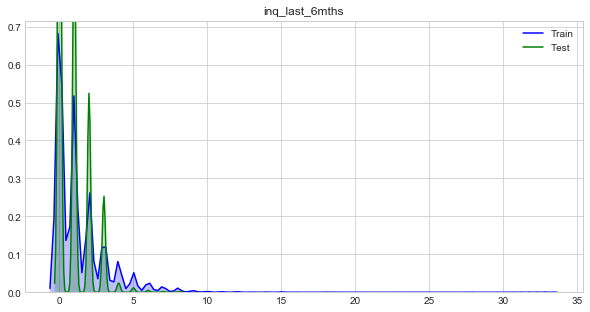

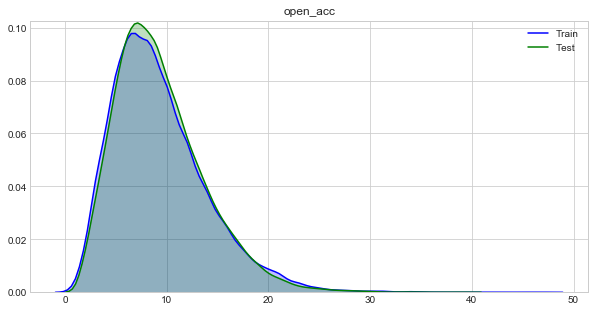

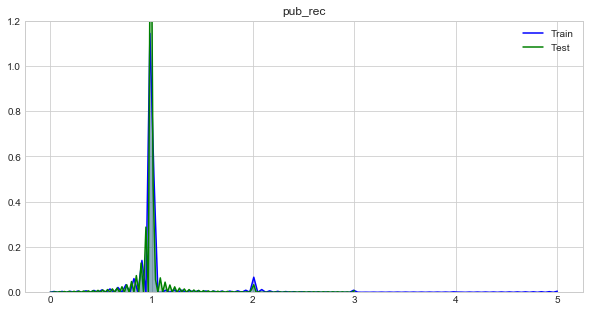

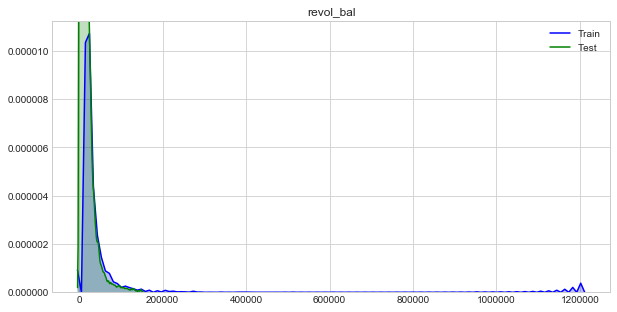

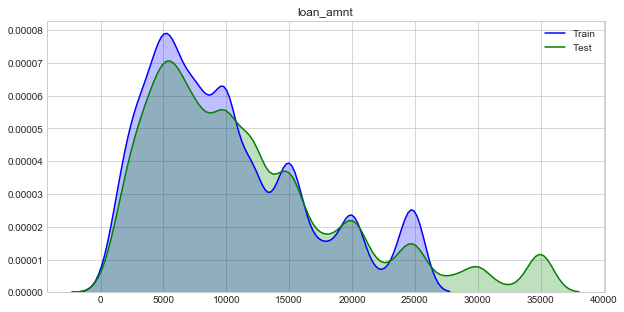

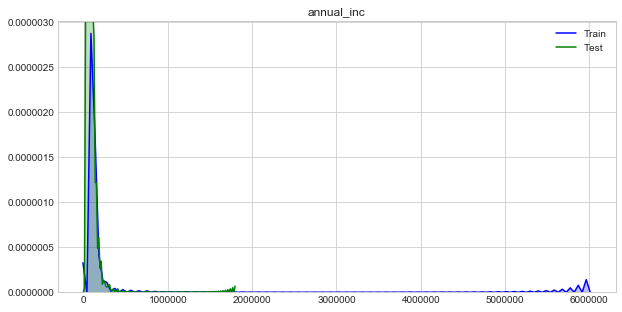

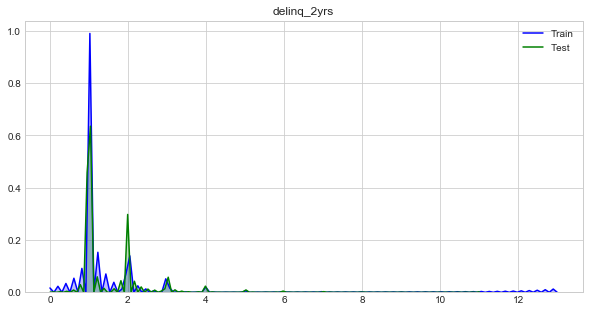

In [115]:
# distribution of train and test set features are similar 
for col in train.columns[:7]:
    fig, ax = plt.subplots()
    
    sns.kdeplot(train1[col], shade = True, label = 'Train', color = 'blue')
    sns.kdeplot(test1[col], shade = True, label = 'Test', color = 'green')
    
    fig.set_size_inches(10, 5)
    plt.title(col)